# Talking Points

Finding the drivers of point total from the 2014-2018 seasons

## Libraries needed for final report

In [88]:
#acquire libraries
import pandas as pd

#explore libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway

from prepare import wrangle_nba, scaled_wrangle_nba
from explore import elbow_plot, run_kmeans, add_to_train

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#model libraries
from model import (select_kbest, rfe, linearReg_train, 
lassoLars_train, poly_linearReg_train, linearReg_validate,
lassoLars_validate, poly_linearReg_validate)

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

## Acquire

In [2]:
#uploading the nba csv and saving it as a dataframe called nba
nba = pd.read_csv('nba.games.stats.csv')

### Initial Analysis of the Data

In [3]:
#sneak peak into the data
nba.head()

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
0,1,ATL,1,2014-10-29,Away,TOR,L,102,109,40,...,27,33,0.818,16,48,26,13,9,9,22
1,2,ATL,2,2014-11-01,Home,IND,W,102,92,35,...,18,21,0.857,11,44,25,5,5,18,26
2,3,ATL,3,2014-11-05,Away,SAS,L,92,94,38,...,27,38,0.711,11,50,25,7,9,19,15
3,4,ATL,4,2014-11-07,Away,CHO,L,119,122,43,...,20,27,0.741,11,51,31,6,7,19,30
4,5,ATL,5,2014-11-08,Home,NYK,W,103,96,33,...,8,11,0.727,13,44,26,2,6,15,29


In [4]:
nba.tail()

,Unnamed: 0,Team,Game,Date,Home,Opponent,WINorLOSS,TeamPoints,OpponentPoints,FieldGoals,...,Opp.FreeThrows,Opp.FreeThrowsAttempted,Opp.FreeThrows.,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls
9835,78119,WAS,78,2018-04-03,Away,HOU,L,104,120,38,...,18,27,0.667,10,46,26,13,3,9,14
9836,79119,WAS,79,2018-04-05,Away,CLE,L,115,119,47,...,22,28,0.786,5,35,26,10,3,16,14
9837,80119,WAS,80,2018-04-06,Home,ATL,L,97,103,35,...,16,23,0.696,7,50,24,5,5,18,22
9838,81124,WAS,81,2018-04-10,Home,BOS,W,113,101,41,...,22,27,0.815,13,44,22,14,1,16,18
9839,82119,WAS,82,2018-04-11,Away,ORL,L,92,101,33,...,22,27,0.815,6,42,20,6,7,16,27


In [5]:
#checking to see how many rows and columns there are
nba.shape

(9840, 41)

In [6]:
#checking data types, null values, and column names
nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9840 entries, 0 to 9839
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                9840 non-null   int64  
 1   Team                      9840 non-null   object 
 2   Game                      9840 non-null   int64  
 3   Date                      9840 non-null   object 
 4   Home                      9840 non-null   object 
 5   Opponent                  9840 non-null   object 
 6   WINorLOSS                 9840 non-null   object 
 7   TeamPoints                9840 non-null   int64  
 8   OpponentPoints            9840 non-null   int64  
 9   FieldGoals                9840 non-null   int64  
 10  FieldGoalsAttempted       9840 non-null   int64  
 11  FieldGoals.               9840 non-null   float64
 12  X3PointShots              9840 non-null   int64  
 13  X3PointShotsAttempted     9840 non-null   int64  
 14  X3PointS

In [7]:
#looking at the summary statistics of all the numeric columns
nba.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,9840.0,11960.157012,18654.867508,1.000,2537.750,5141.500,7715.250,82119.000
Game,9840.0,41.500000,23.670804,1.000,21.000,41.500,62.000,82.000
TeamPoints,9840.0,103.652337,12.188043,64.000,95.000,103.000,112.000,149.000
OpponentPoints,9840.0,103.652337,12.188043,64.000,95.000,103.000,112.000,149.000
FieldGoals,9840.0,38.602439,5.029992,19.000,35.000,38.000,42.000,58.000
FieldGoalsAttempted,9840.0,84.902439,7.130043,60.000,80.000,85.000,89.000,129.000
FieldGoals.,9840.0,0.455689,0.054711,0.271,0.418,0.455,0.494,0.684
X3PointShots,9840.0,9.126829,3.598084,0.000,7.000,9.000,11.000,25.000
X3PointShotsAttempted,9840.0,25.623679,7.102501,4.000,21.000,25.000,30.000,61.000
X3PointShots.,9840.0,0.354321,0.097782,0.000,0.290,0.353,0.419,0.750


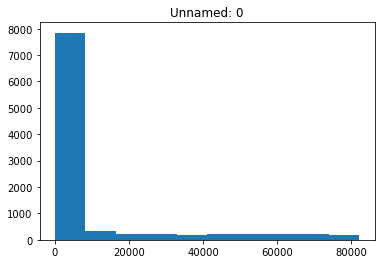

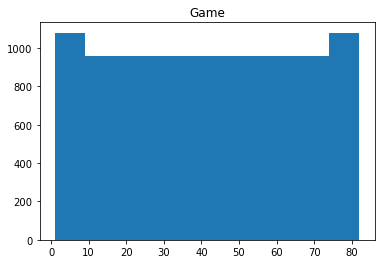

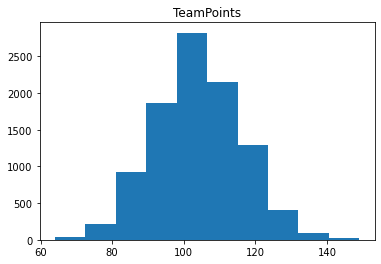

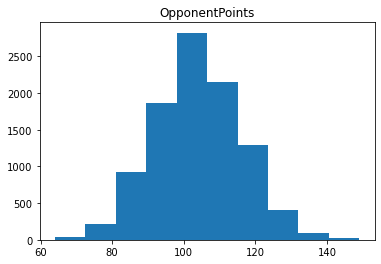

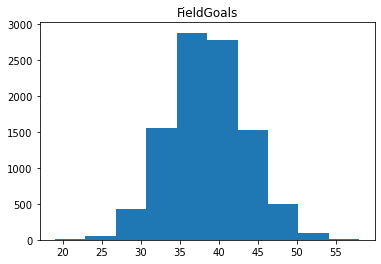

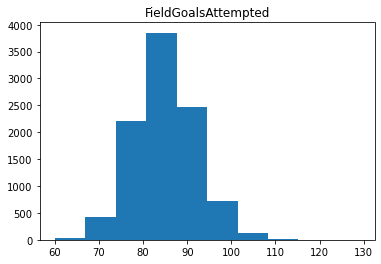

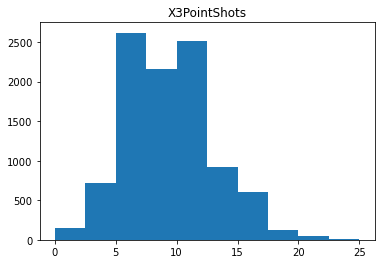

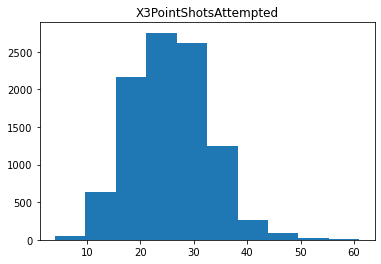

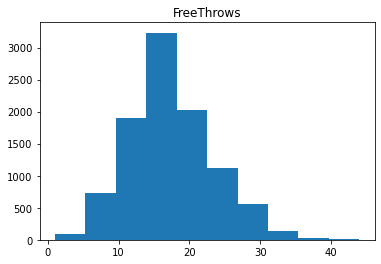

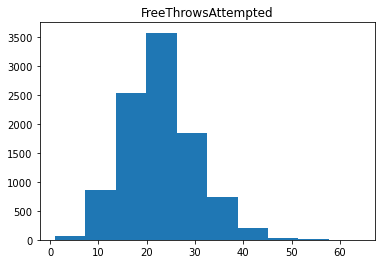

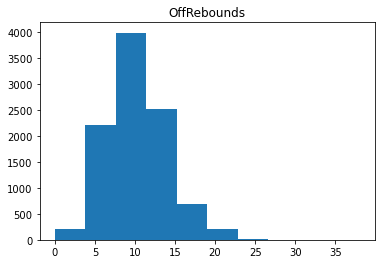

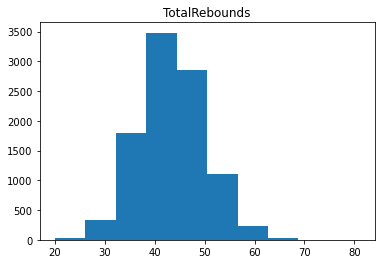

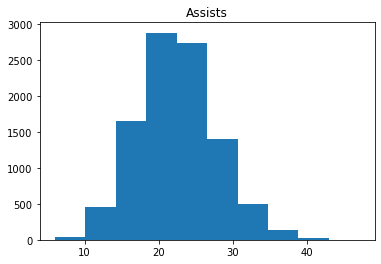

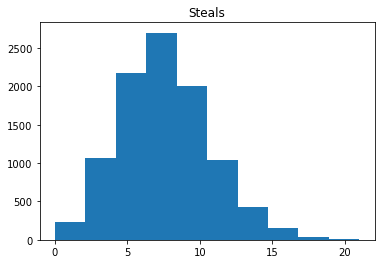

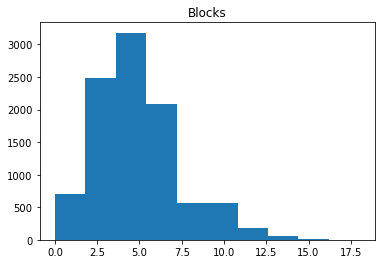

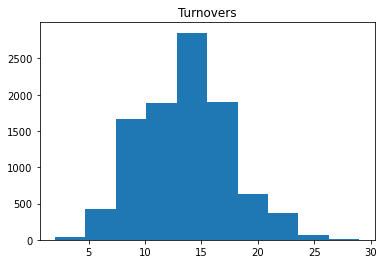

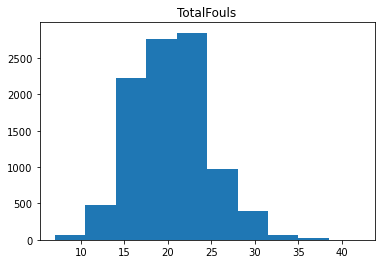

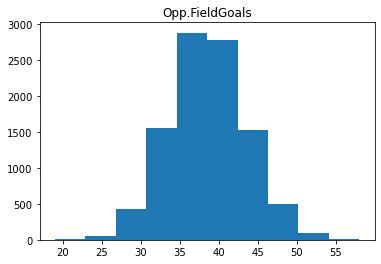

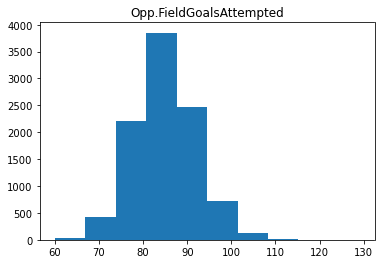

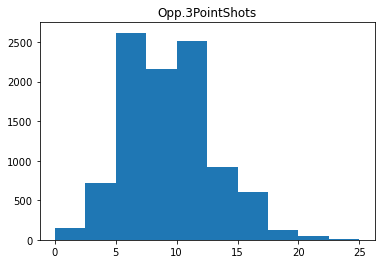

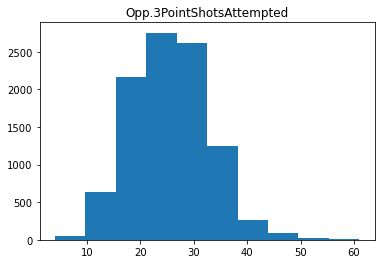

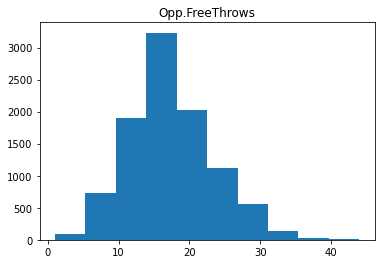

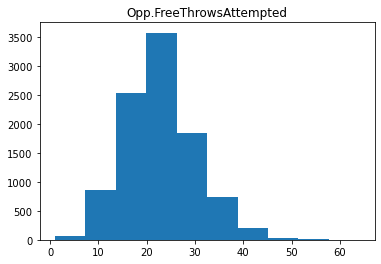

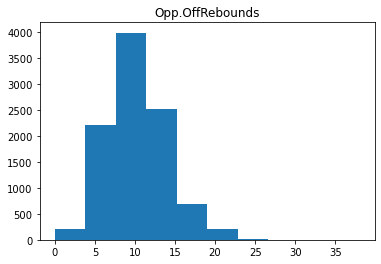

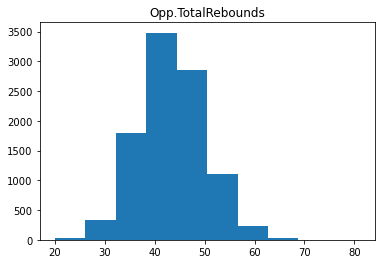

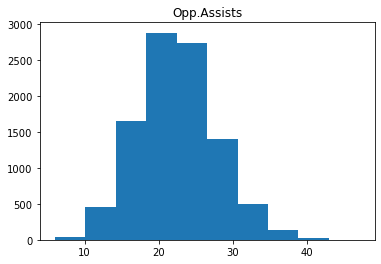

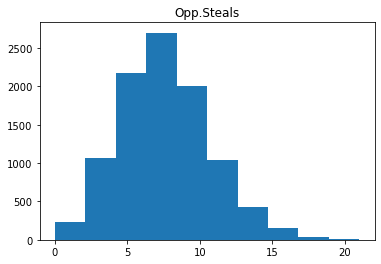

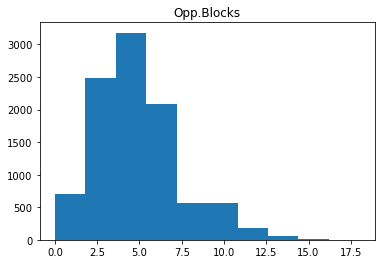

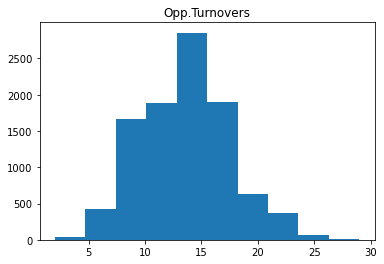

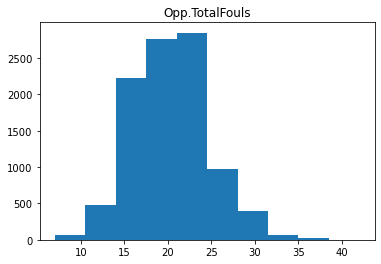

In [8]:
#checking plot distribution for all numerical columns
num_cols = nba.columns[[nba[col].dtype == 'int64' for col in nba.columns]]
for col in num_cols:
    plt.hist(nba[col])
    plt.title(col)
    plt.show()

<div class="alert alert-block alert-info"><b>Acquire Summary:</b>
    
* We will delete unnamed column because it wont be necessary
    
* We won't need game number because it will be in the index 
    
* Four seasons worth of data, we could look into splitting up the seasons 
    
* No null values, BIG PLUS! 
    
* Some outliers but its just a part of the game. Will keep all the data but could consider removing the outliers later 
    
* Normal distribution for all of the numerical columns
    
</div>

## Prepare

<div class="alert alert-block alert-info">
    
- adding two columns called home_is_west and away_is_west for teams playing in different conferences 
- Changed Home, Conference, Opp.Conference and Wins into dummy variables 
- dropped dates and columns that deal with point totals to not skew the models to predict who wins 
- split into train, validate and test
    
</div>

## Explore

In [9]:
train, validate, test = wrangle_nba()

In [10]:
X_train = train.drop(columns = ['Team', 'Opponent', 'TeamPoints'])
y_train = train.TeamPoints

In [11]:
train.head()

,Team,Opponent,TeamPoints,FieldGoals.,X3PointShots.,FreeThrows.,OffRebounds,TotalRebounds,Assists,Steals,...,Opp.OffRebounds,Opp.TotalRebounds,Opp.Assists,Opp.Steals,Opp.Blocks,Opp.Turnovers,Opp.TotalFouls,home_is_west,away_is_west,Home
7544,BRK,IND,131,0.479,0.400,0.906,11,43,22,7,...,14,47,29,12,9,14,25,0,0,0
3403,IND,PHO,97,0.410,0.200,0.735,10,46,14,16,...,13,53,15,4,2,22,23,0,1,0
8265,HOU,DAL,105,0.464,0.378,0.714,6,45,21,5,...,17,53,27,5,2,10,18,1,1,0
2225,TOR,MIL,124,0.523,0.600,0.792,15,57,27,8,...,8,30,19,11,1,12,18,0,0,1
5027,BOS,CHO,96,0.436,0.321,0.731,5,46,26,7,...,16,53,21,10,4,12,21,0,0,1


In [12]:
abs(train.corr().TeamPoints).sort_values(ascending = False)

TeamPoints           1.000000
FieldGoals.          0.715916
Assists              0.581885
X3PointShots.        0.479659
Opp.TotalRebounds    0.294783
Opp.TotalFouls       0.211711
FreeThrows.          0.178378
TotalFouls           0.149589
Opp.Blocks           0.141265
Turnovers            0.118230
Opp.Assists          0.118153
Home                 0.104941
Opp.FieldGoals.      0.102473
Opp.Steals           0.099355
Steals               0.093689
TotalRebounds        0.092601
home_is_west         0.079488
Blocks               0.060732
Opp.3PointShots.     0.034682
Opp.FreeThrows.      0.023883
Opp.Turnovers        0.023673
away_is_west         0.022586
Opp.OffRebounds      0.012581
OffRebounds          0.008963
Name: TeamPoints, dtype: float64

### Are the Home team point totals dramatically different from the Away team points?

- $H_0$: The average points scored by Home and Away teams are not significantly different
- $H_a$: The average points scored by Home and Away teams are significantly different

In [13]:
alpha = 0.01

In [14]:
home = train[train.Home == 1]
away = train[train.Home == 0]

t, p = stats.ttest_ind(home.TeamPoints, away.TeamPoints)

In [15]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


5.740461831462349e-15

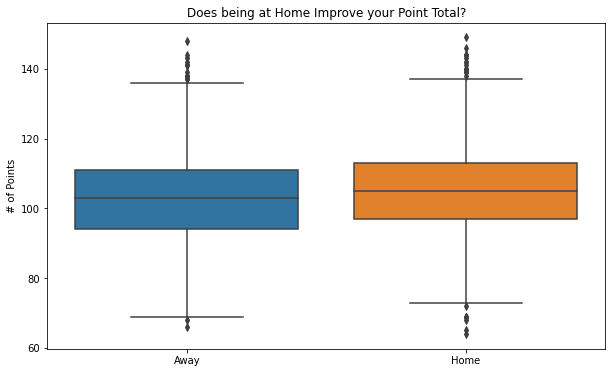

In [16]:
plt.figure(figsize=(10,6))
sns.boxplot(x="Home", y="TeamPoints", data=train)
plt.title('Does being at Home Improve your Point Total?')
plt.xticks([0, 1], ['Away', 'Home'])
plt.ylabel('# of Points')
plt.xlabel('')
plt.show()

In [17]:
print("The average points scored for the Home team is", round(train[train.Home == 1].TeamPoints.mean(),2))

The average points scored for the Home team is 105.26


In [18]:
print("The average points scored for the Away team is", round(train[train.Home == 0].TeamPoints.mean(),2))

The average points scored for the Away team is 102.69


**Takeaway**:
- The difference between 105 and 103 points is not a big numerical difference but the evidence suggest that it is a significant one.

### Do Home teams in the West score more points than Home teams in the East?

- $H_0$: The average points scored by West and East Home teams are not significantly different
- $H_a$: The average points scored by West and East Home teams are significantly different

In [19]:
home_west = train[train.home_is_west == 1]
home_east = train[train.home_is_west == 0]

t, p = stats.ttest_ind(home_west.TeamPoints, home_east.TeamPoints)

In [20]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We reject the null hypothesis


3.454692117851272e-09

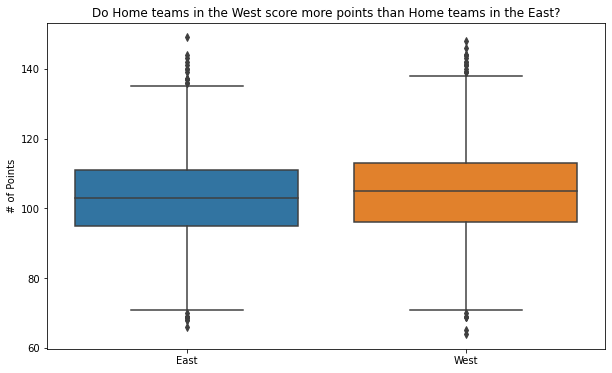

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x="home_is_west", y="TeamPoints", data=train)
plt.title('Do Home teams in the West score more points than Home teams in the East?')
plt.xticks([0, 1], ['East', 'West'])
plt.ylabel('# of Points')
plt.xlabel('')
plt.show()

In [22]:
print("The average points scored for the Home team in the West is", round(train[train.home_is_west == 1].TeamPoints.mean(),2))

The average points scored for the Home team in the West is 104.96


In [23]:
print("The average points scored for the Home team in the East is", round(train[train.home_is_west == 0].TeamPoints.mean(),2))

The average points scored for the Home team in the East is 103.01


**Takeaway**:
- The difference between 105 and 103 points is not a big numerical difference but the evidence suggest that it is a significant one.

### Do Away teams in the West score more points than Away teams in the East?

- $H_0$: The average points scored by West and East Away teams are not significantly different
- $H_a$: The average points scored by West and East Away teams are significantly different

In [24]:
away_west = train[train.away_is_west == 1]
away_east = train[train.away_is_west == 0]

t, p = stats.ttest_ind(away_west.TeamPoints, away_east.TeamPoints)

In [25]:
if p < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")
p

We fail to reject the null hypothesis


0.09366749466158963

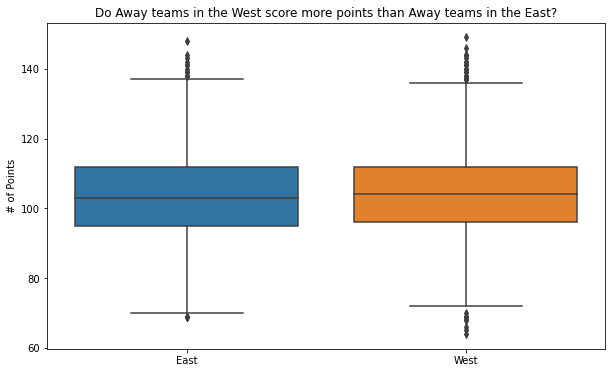

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(x="away_is_west", y="TeamPoints", data=train)
plt.title('Do Away teams in the West score more points than Away teams in the East?')
plt.xticks([0, 1], ['East', 'West'])
plt.ylabel('# of Points')
plt.xlabel('')
plt.show()

In [27]:
print("The average points scored for the Away team in the West is", round(train[train.away_is_west == 1].TeamPoints.mean(),2))

The average points scored for the Away team in the West is 104.26


In [28]:
print("The average points scored for the Away team in the East is", round(train[train.away_is_west == 0].TeamPoints.mean(),2))

The average points scored for the Away team in the East is 103.71


**Takeaway**:
- The data shows that the points scored by an Away East team and an Away West team is only half a point
- The difference is not significant enough to state one conference score more points than the other when they are away. 

### Is there a significant difference between points scored by a team and their opponents blocks?

- $H_0$: The average points scored by a team and the number of their opponents blocks are not significantly different
- $H_a$: The average points scored by a team and the number of their opponents blocks are significantly different

In [29]:
train['Opp.Blocks'].value_counts()

4     972
5     822
3     821
6     659
2     573
7     491
8     323
1     289
9     197
0     105
10    104
11     83
12     30
13     25
14      9
15      3
16      2
17      2
Name: Opp.Blocks, dtype: int64

In [30]:
no_blocks = train[train['Opp.Blocks'] == 0].TeamPoints
one_blocks = train[train['Opp.Blocks'] == 1].TeamPoints
two_blocks = train[train['Opp.Blocks'] == 2].TeamPoints
three_blocks = train[train['Opp.Blocks'] == 3].TeamPoints
four_blocks = train[train['Opp.Blocks'] == 4].TeamPoints
five_blocks = train[train['Opp.Blocks'] == 5].TeamPoints
six_blocks = train[train['Opp.Blocks'] == 6].TeamPoints
seven_blocks = train[train['Opp.Blocks'] == 7].TeamPoints
eight_blocks = train[train['Opp.Blocks'] == 8].TeamPoints
nine_blocks = train[train['Opp.Blocks'] == 9].TeamPoints
ten_blocks = train[train['Opp.Blocks'] == 10].TeamPoints
eleven_blocks = train[train['Opp.Blocks'] == 11].TeamPoints
twelve_blocks = train[train['Opp.Blocks'] == 12].TeamPoints
thirteen_blocks = train[train['Opp.Blocks'] == 13].TeamPoints
fourteen_blocks = train[train['Opp.Blocks'] == 14].TeamPoints
fifteen_blocks = train[train['Opp.Blocks'] == 15].TeamPoints
sixteen_blocks = train[train['Opp.Blocks'] == 16].TeamPoints
seventeen_blocks = train[train['Opp.Blocks'] == 17].TeamPoints

In [31]:
f, p = f_oneway(no_blocks, one_blocks, two_blocks, three_blocks, four_blocks, five_blocks, six_blocks, seven_blocks, eight_blocks, nine_blocks, ten_blocks, eleven_blocks, twelve_blocks, thirteen_blocks, fourteen_blocks, fifteen_blocks, sixteen_blocks, seventeen_blocks)

In [32]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


1.51080949193264e-18

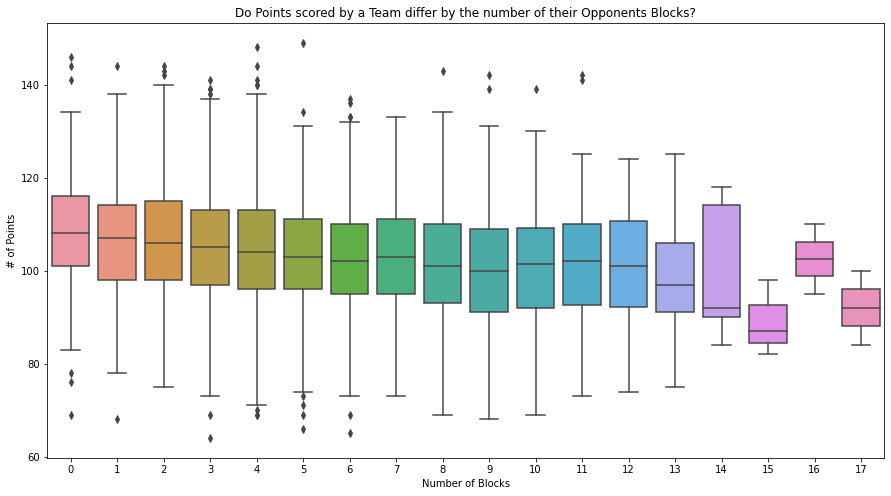

In [33]:
plt.figure(figsize=(15,8))
sns.boxplot(x="Opp.Blocks", y="TeamPoints", data=train)
plt.title('Do Points scored by a Team differ by the number of their Opponents Blocks?')
plt.ylabel('# of Points')
plt.xlabel('Number of Blocks')
plt.show()

**Takeaway**:
- The data shows that there difference is a significant difference to between points scored by a team and the number of their opponents blocks.
- It appears that as the number of blocks by their opponents increase, the amoun of points scored by a team decreases.
- There are a few outliers and exceptions but there is a very small sample size for opponents blocks for numbers greater than 10.

## Clustering

In [34]:
train_scaled, validate_scaled, test_scaled = scaled_wrangle_nba()

In [35]:
X_train_scaled = train_scaled.drop(columns = ['Team', 'Opponent', 'TeamPoints'])
y_train = train.TeamPoints

X_validate_scaled = validate_scaled.drop(columns = ['Team', 'Opponent', 'TeamPoints'])
y_validate = validate.TeamPoints

X_test_scaled = test_scaled.drop(columns = ['Team', 'Opponent', 'TeamPoints'])
y_test = test.TeamPoints

In [36]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5510 entries, 7544 to 8130
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Team                      5510 non-null   object 
 1   Opponent                  5510 non-null   object 
 2   TeamPoints                5510 non-null   int64  
 3   home_is_west              5510 non-null   uint8  
 4   away_is_west              5510 non-null   uint8  
 5   Home                      5510 non-null   uint8  
 6   FieldGoals._scaled        5510 non-null   float64
 7   X3PointShots._scaled      5510 non-null   float64
 8   FreeThrows._scaled        5510 non-null   float64
 9   OffRebounds_scaled        5510 non-null   float64
 10  TotalRebounds_scaled      5510 non-null   float64
 11  Assists_scaled            5510 non-null   float64
 12  Steals_scaled             5510 non-null   float64
 13  Blocks_scaled             5510 non-null   float64
 14  Turno

- For clustering, we can take the columns above and start to group them by like columns
- `FieldGoals._scaled`, `X3PointShots._scaled`, and `FreeThrows._scaled` are related to shooting percentage.
- `Steals_scaled` and `Blocks_scaled` are related to defense
- `Assists_scaled`and `Turnovers_scaled` are two categories that are helping or hurting your defense. Often create a ratio of this in basketball
- We will have the same 3 sets above but for the opposing teams stats

In [37]:
shooting_vars = ['FieldGoals._scaled', 'X3PointShots._scaled', 'FreeThrows._scaled']

defense_vars = ['Steals_scaled', 'Blocks_scaled']

assist_turnover_vars = ['Assists_scaled', 'Turnovers_scaled']

opp_shooting_vars = ['Opp.FieldGoals._scaled', 'Opp.3PointShots._scaled', 'Opp.FreeThrows._scaled']

opp_defense_vars = ['Opp.Steals_scaled', 'Opp.Blocks_scaled']

opp_assist_turnover_vars = ['Opp.Assists_scaled', 'Opp.Turnovers_scaled']

### Shooting Cluster

In [38]:
shooting_vars

['FieldGoals._scaled', 'X3PointShots._scaled', 'FreeThrows._scaled']

     k         sse
0    2  182.656349
1    3  147.755398
2    4  124.416933
3    5  112.107692
4    6  100.499586
5    7   92.374748
6    8   85.009769
7    9   79.550013
8   10   75.158199
9   11   71.016115
10  12   67.290164
11  13   64.426608
12  14   61.724259
13  15   59.441256
14  16   56.806884
15  17   54.789531
16  18   53.096737
17  19   51.375083


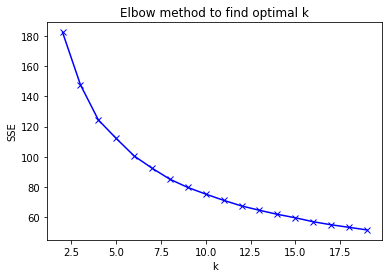

In [39]:
elbow_plot(shooting_vars, X_train_scaled)

- The elbow seems to peak around 4

In [40]:
train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['FieldGoals._scaled', 'X3PointShots._scaled', 'FreeThrows._scaled'], 
                                    cluster_col_name = 'shooting_cluster', X_train_scaled = X_train_scaled)

In [41]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'shooting_cluster', X_train = train, X_train_scaled = X_train_scaled)

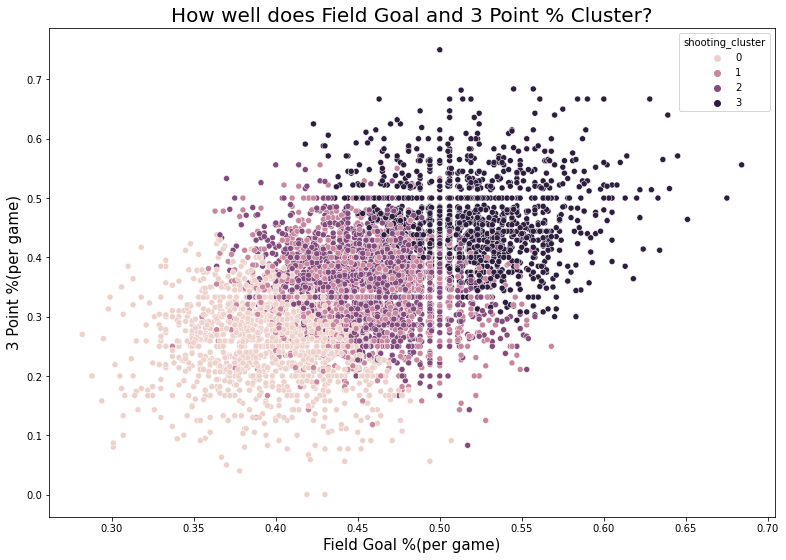

In [42]:
plt.figure(figsize = (13,9))
sns.scatterplot(x='FieldGoals.', y='X3PointShots.', hue='shooting_cluster', data=X_train)
plt.title("How well does Field Goal and 3 Point % Cluster?", size = 20)
plt.xlabel("Field Goal %(per game)", size = 15)
plt.ylabel("3 Point %(per game)", size = 15)
plt.show()

**Takeaway**:
- cluster 0 and 4 seem to have a clear defined area between them but the other 2 clusters blend a significant amount
- There seems to be a linear relationship between the shooting percentages. As one increases so does the other

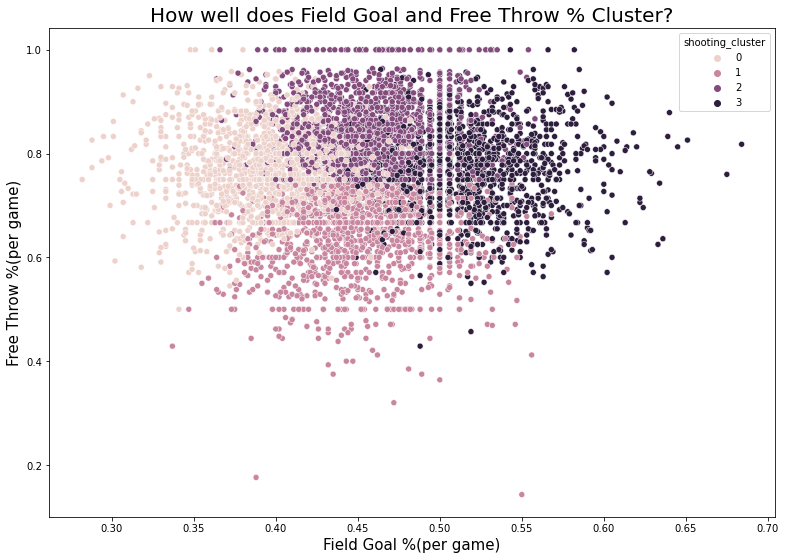

In [43]:
plt.figure(figsize = (13,9))
sns.scatterplot(x='FieldGoals.', y='FreeThrows.', hue='shooting_cluster', data=X_train)
plt.title("How well does Field Goal and Free Throw % Cluster?", size = 20)
plt.xlabel("Field Goal %(per game)", size = 15)
plt.ylabel("Free Throw %(per game)", size = 15)
plt.show()

**Takeaway**:
- Here we have some clear defined clusters with a little overlap but a great representation of what we are looking for 
- The four groups seem to be
    - those who shoot the field goals well
    - those who do not shoot field goals well
    - those who shoot field goals at an average rate but shoot free throws well
    - those who shoot fields goals at an average rate but do not shoot free throws well

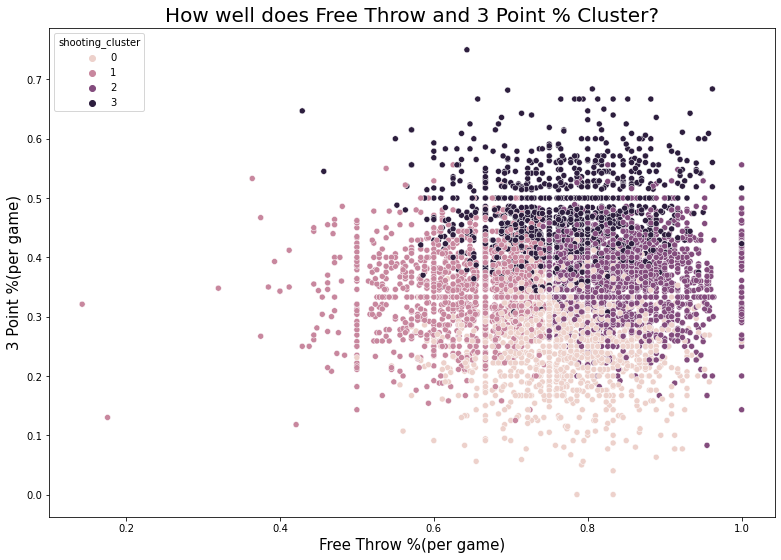

In [44]:
plt.figure(figsize = (13,9))
sns.scatterplot(x='FreeThrows.', y='X3PointShots.', hue='shooting_cluster', data=X_train)
plt.title("How well does Free Throw and 3 Point % Cluster?", size = 20)
plt.xlabel("Free Throw %(per game)", size = 15)
plt.ylabel("3 Point %(per game)", size = 15)
plt.show()

**Takeaway**:
- There is a blend of clusters with all of the point meeting in the middle. 
- The four groups seem to be
    - those who shoot the 3 well
    - those who do not shoot the 3 well
    - those who shoot the 3 at an average rate but shoot free throws well
    - those who shoot the 3 at an average rate but do not shoot free throws well

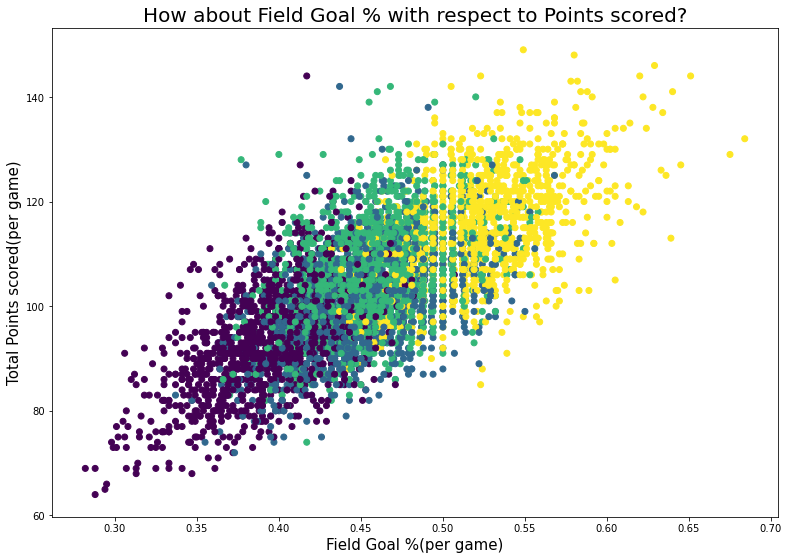

In [45]:
plt.figure(figsize = (13,9))
plt.scatter(X_train['FieldGoals.'], y_train, c=X_train.shooting_cluster)
plt.title("How about Field Goal % with respect to Points scored?", size = 20)
plt.xlabel("Field Goal %(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway**:
- There is a tight linear relationship with a lot of overlap in the middle

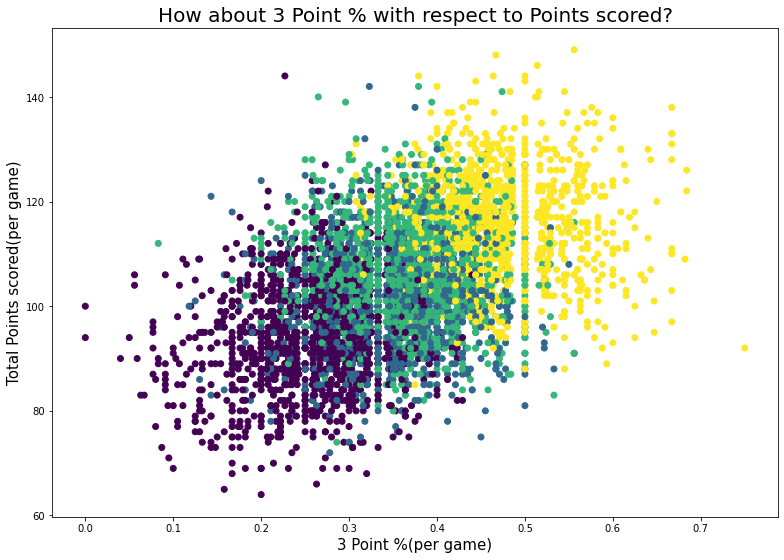

In [46]:
plt.figure(figsize = (13,9))
plt.scatter(X_train['X3PointShots.'], y_train, c=X_train.shooting_cluster)
plt.title("How about 3 Point % with respect to Points scored?", size = 20)
plt.xlabel("3 Point %(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway**:
- loose linear relationship 

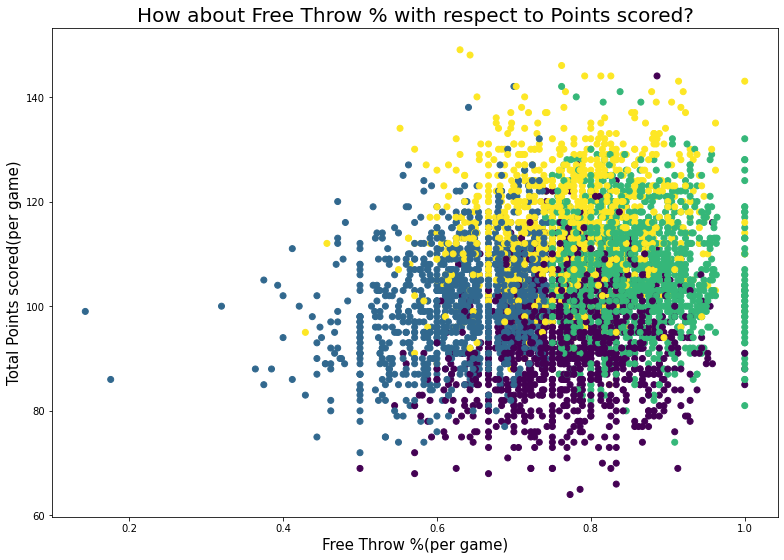

In [47]:
plt.figure(figsize = (13,9))
plt.scatter(X_train['FreeThrows.'], y_train, c=X_train.shooting_cluster)
plt.title("How about Free Throw % with respect to Points scored?", size = 20)
plt.xlabel("Free Throw %(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway**:
- Does not appear to have a linear realtionship but does have an assortment of clusters.

- Clusters 0 and 3 may be significant enough to use but further testing will be required

In [48]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5510 entries, 7544 to 8130
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Team               5510 non-null   object 
 1   Opponent           5510 non-null   object 
 2   TeamPoints         5510 non-null   int64  
 3   FieldGoals.        5510 non-null   float64
 4   X3PointShots.      5510 non-null   float64
 5   FreeThrows.        5510 non-null   float64
 6   OffRebounds        5510 non-null   int64  
 7   TotalRebounds      5510 non-null   int64  
 8   Assists            5510 non-null   int64  
 9   Steals             5510 non-null   int64  
 10  Blocks             5510 non-null   int64  
 11  Turnovers          5510 non-null   int64  
 12  TotalFouls         5510 non-null   int64  
 13  Opp.FieldGoals.    5510 non-null   float64
 14  Opp.3PointShots.   5510 non-null   float64
 15  Opp.FreeThrows.    5510 non-null   float64
 16  Opp.OffRebounds    55

### Is there a significant difference in total point scored between shooting clusters?

- $H_0$: The total points scored is the same across all shooting clusters
- $H_a$: The total points scored is not the same across all shooting clusters

In [49]:
cluster0 = train[train.shooting_cluster == 0].TeamPoints
cluster1 = train[train.shooting_cluster == 1].TeamPoints
cluster2 = train[train.shooting_cluster == 2].TeamPoints
cluster3 = train[train.shooting_cluster == 3].TeamPoints

In [50]:
f, p = f_oneway(cluster0, cluster1, cluster2, cluster3)

In [51]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


0.0

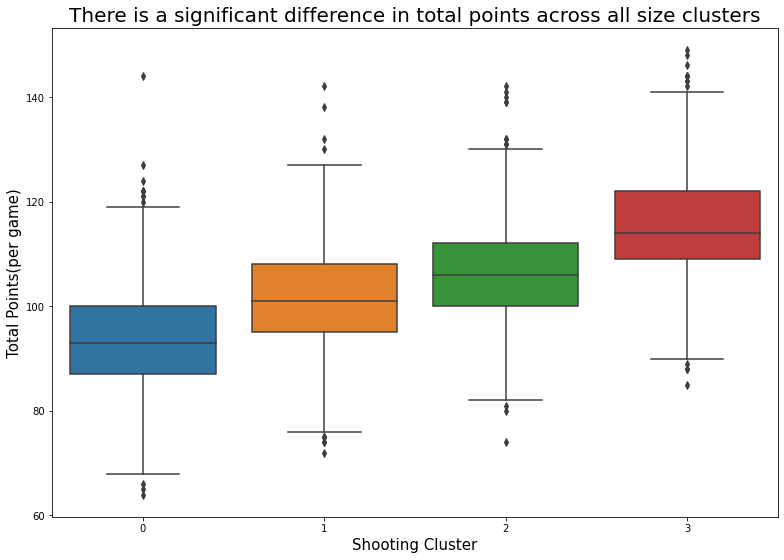

In [52]:
plt.figure(figsize = (13,9))
sns.boxplot(X_train.shooting_cluster, y_train)
plt.title("There is a significant difference in total points across all size clusters", size = 20)
plt.xlabel("Shooting Cluster", size = 15)
plt.ylabel("Total Points(per game)", size = 15)
plt.show()


**Takeaways:**
- Since there is a significant difference, we will add them to our validate and test data set.

In [53]:
train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['FieldGoals._scaled', 'X3PointShots._scaled', 'FreeThrows._scaled'], 
                                    cluster_col_name = 'shooting_cluster', X_train_scaled = X_validate_scaled)

X_validate_scaled = pd.concat([X_validate_scaled, train_clusters], axis=1)

train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['FieldGoals._scaled', 'X3PointShots._scaled', 'FreeThrows._scaled'], 
                                    cluster_col_name = 'shooting_cluster', X_train_scaled = X_test_scaled)

X_test_scaled = pd.concat([X_test_scaled, train_clusters], axis=1)

### Defensive Cluster

In [54]:
defense_vars

['Steals_scaled', 'Blocks_scaled']

     k         sse
0    2  155.168359
1    3  102.544558
2    4   84.234274
3    5   69.229933
4    6   56.763726
5    7   50.000470
6    8   45.638404
7    9   40.212519
8   10   37.034453
9   11   33.552414
10  12   31.173040
11  13   28.547422
12  14   27.040883
13  15   25.285785
14  16   23.539307
15  17   22.421338
16  18   21.187470
17  19   20.147827


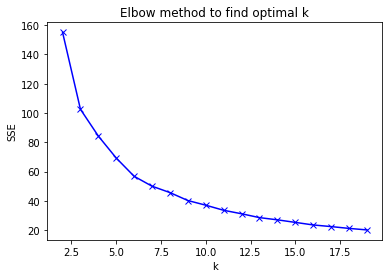

In [55]:
elbow_plot(defense_vars, X_train_scaled)

- the elbow seems to peek at around 3

In [56]:
train_clusters, kmeans = run_kmeans(3,  cluster_vars = ['Steals_scaled', 'Blocks_scaled'], 
                                    cluster_col_name = 'defense_cluster', X_train_scaled = X_train_scaled)

In [57]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'defense_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

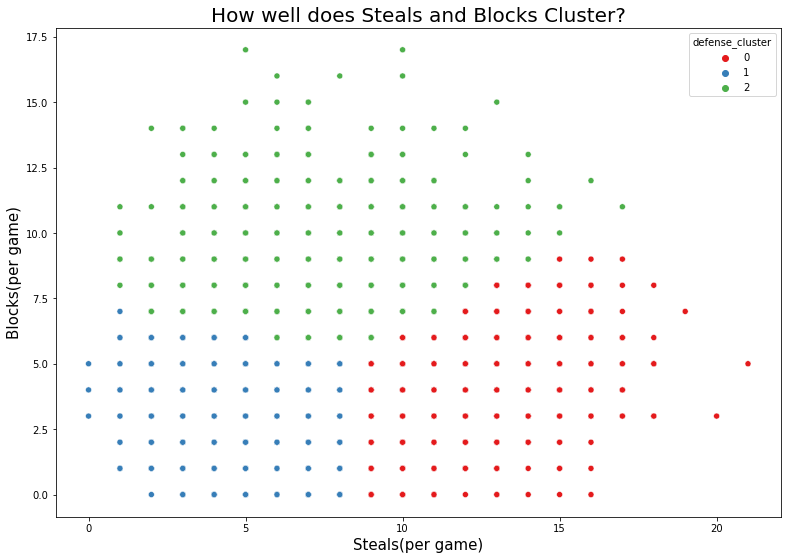

In [58]:
plt.figure(figsize = (13,9))
sns.color_palette("tab10")
sns.scatterplot(x='Steals', y='Blocks', hue='defense_cluster', data=X_train, palette = 'Set1')
plt.title("How well does Steals and Blocks Cluster?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Blocks(per game)", size = 15)
plt.show()

**Takeaways:**
- Here we have some clear defined clusters
- The three groups seem to be
    - Those who have a lot of blocks and any amount of steals
    - Those who have less than league average of blocks but a lot of steals
    - Those who have less than league average of blocks and very little steals

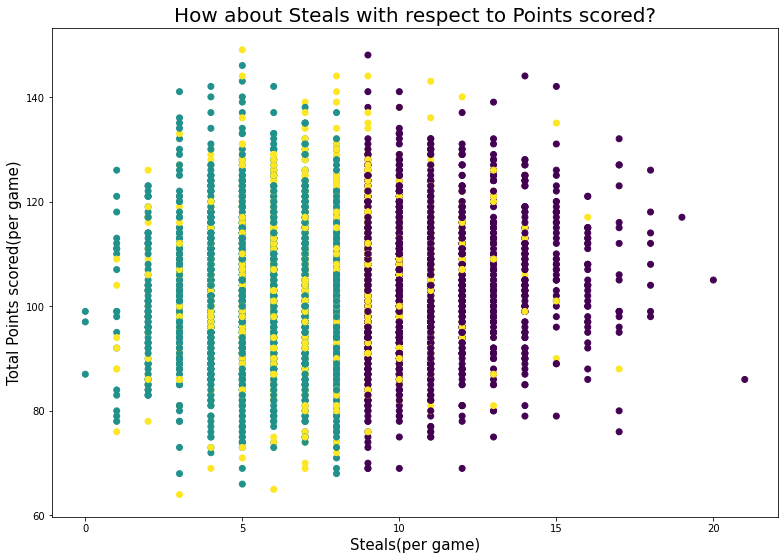

In [59]:
plt.figure(figsize = (13,9))
plt.scatter(train.Steals, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Steals with respect to Points scored?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The cluster with more than average steals and less than average steals is well defined but the blocks cluster is all mixed in between

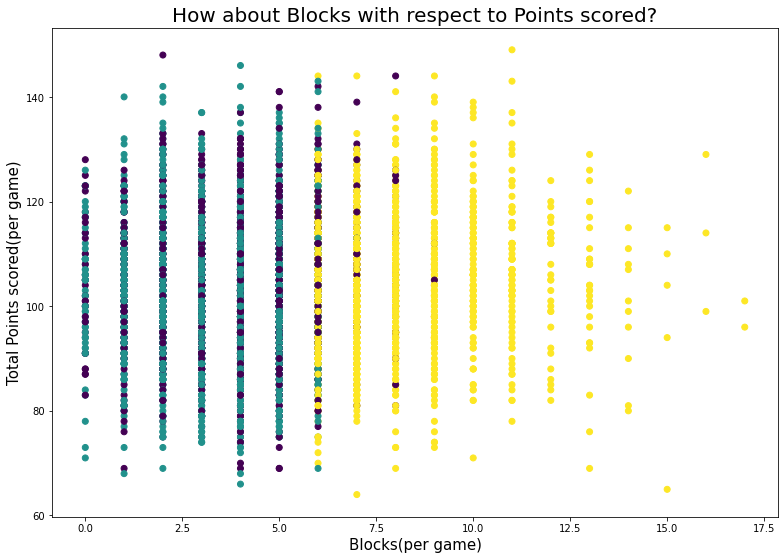

In [60]:
plt.figure(figsize = (13,9))
plt.scatter(train.Blocks, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Blocks with respect to Points scored?", size = 20)
plt.xlabel("Blocks(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [61]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5510 entries, 7544 to 8130
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Team               5510 non-null   object 
 1   Opponent           5510 non-null   object 
 2   TeamPoints         5510 non-null   int64  
 3   FieldGoals.        5510 non-null   float64
 4   X3PointShots.      5510 non-null   float64
 5   FreeThrows.        5510 non-null   float64
 6   OffRebounds        5510 non-null   int64  
 7   TotalRebounds      5510 non-null   int64  
 8   Assists            5510 non-null   int64  
 9   Steals             5510 non-null   int64  
 10  Blocks             5510 non-null   int64  
 11  Turnovers          5510 non-null   int64  
 12  TotalFouls         5510 non-null   int64  
 13  Opp.FieldGoals.    5510 non-null   float64
 14  Opp.3PointShots.   5510 non-null   float64
 15  Opp.FreeThrows.    5510 non-null   float64
 16  Opp.OffRebounds    55

### Is there a significant difference in total points scored between defense clusters?

- $H_0$: The total points scored is the same across all defense clusters
- $H_a$: The total points scored is not the same across all defense clusters

In [62]:
cluster0 = train[train.defense_cluster == 0].TeamPoints
cluster1 = train[train.defense_cluster == 1].TeamPoints
cluster2 = train[train.defense_cluster == 2].TeamPoints

In [63]:
f, p = f_oneway(cluster0, cluster1, cluster2)

In [64]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


2.575951822663087e-08

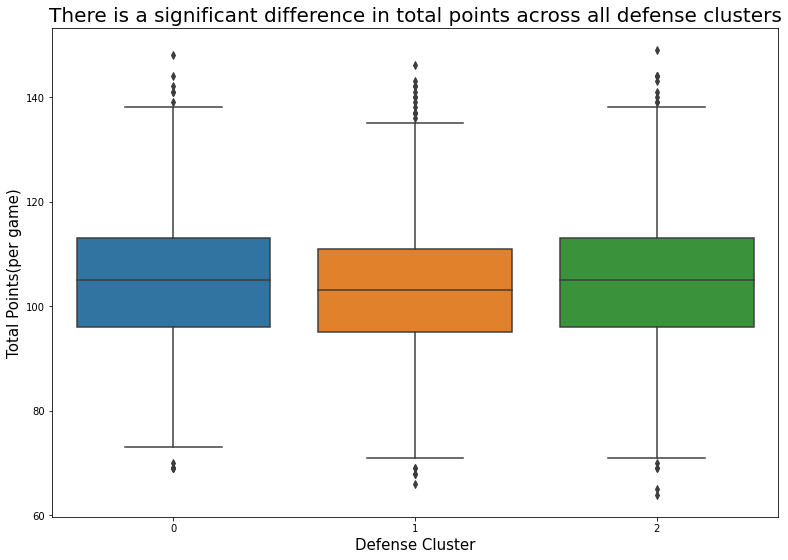

In [65]:
plt.figure(figsize = (13,9))
sns.boxplot(X_train.defense_cluster, y_train)
plt.title("There is a significant difference in total points across all defense clusters", size = 20)
plt.xlabel("Defense Cluster", size = 15)
plt.ylabel("Total Points(per game)", size = 15)
plt.show()

**Takeaway:**
- Since there is a significant difference, we will add them to our validate and test data set.

### Assist/Turnover Cluster

In [66]:
assist_turnover_vars

['Assists_scaled', 'Turnovers_scaled']

     k         sse
0    2  153.984076
1    3  102.886223
2    4   82.879532
3    5   70.219370
4    6   57.472170
5    7   50.582727
6    8   46.126580
7    9   41.475405
8   10   37.319702
9   11   34.371032
10  12   31.879005
11  13   29.895968
12  14   27.688901
13  15   25.901672
14  16   24.491836
15  17   23.168688
16  18   22.092386
17  19   20.904758


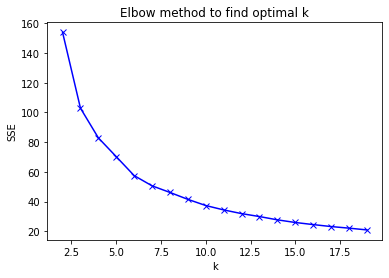

In [67]:
elbow_plot(assist_turnover_vars, X_train_scaled)

In [68]:
train_clusters, kmeans = run_kmeans(3,  cluster_vars = ['Steals_scaled', 'Blocks_scaled'], 
                                    cluster_col_name = 'assist_turnover_cluster', X_train_scaled = X_train_scaled)

In [69]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'assist_turnover_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

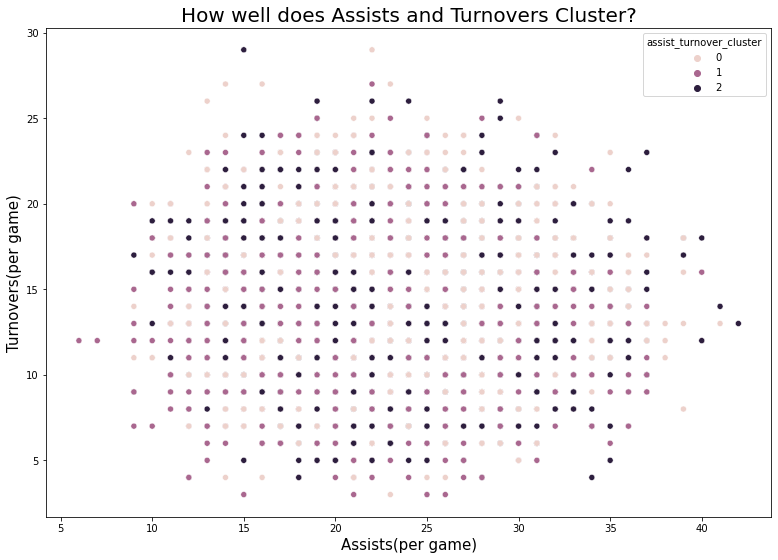

In [78]:
plt.figure(figsize = (13,9))
sns.color_palette("tab10")
sns.scatterplot(x='Assists', y='Turnovers', hue='assist_turnover_cluster', data=X_train)
plt.title("How well does Assists and Turnovers Cluster?", size = 20)
plt.xlabel("Assists(per game)", size = 15)
plt.ylabel("Turnovers(per game)", size = 15)
plt.show()

**Takeaways:** 
- There seems to be no significant clusters.

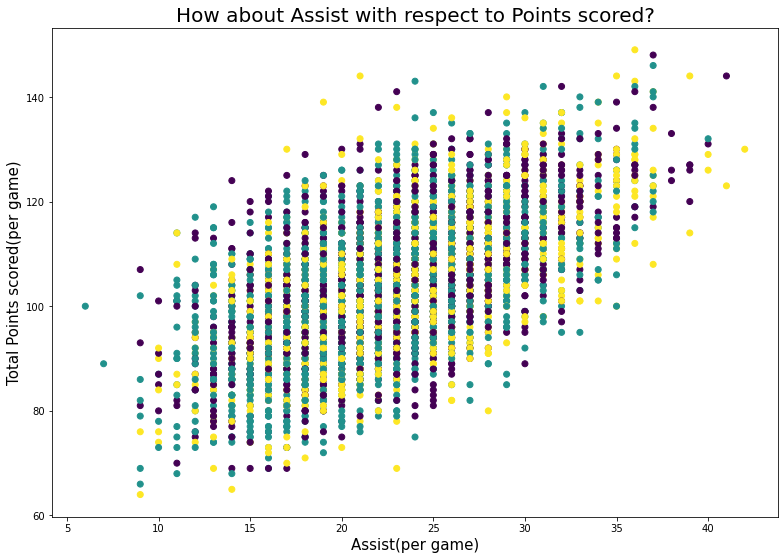

In [81]:
plt.figure(figsize = (13,9))
plt.scatter(train.Assists, train.TeamPoints, c=X_train.assist_turnover_cluster)
plt.title("How about Assist with respect to Points scored?", size = 20)
plt.xlabel("Assist(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- There is a linear correlation but no significant clusters

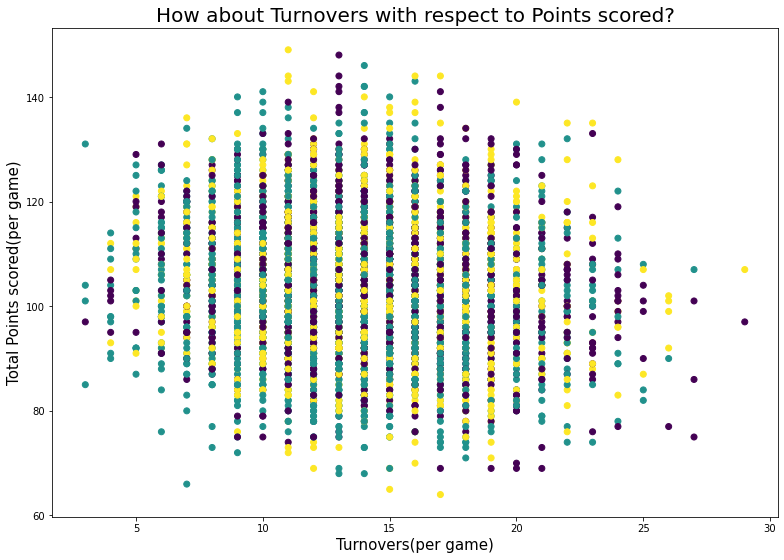

In [82]:
plt.figure(figsize = (13,9))
plt.scatter(train.Turnovers, train.TeamPoints, c=X_train.assist_turnover_cluster)
plt.title("How about Turnovers with respect to Points scored?", size = 20)
plt.xlabel("Turnovers(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- There are still no significant clusters but we will do a statistical test to see if they are significantly different

In [73]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5510 entries, 7544 to 8130
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Team                     5510 non-null   object 
 1   Opponent                 5510 non-null   object 
 2   TeamPoints               5510 non-null   int64  
 3   FieldGoals.              5510 non-null   float64
 4   X3PointShots.            5510 non-null   float64
 5   FreeThrows.              5510 non-null   float64
 6   OffRebounds              5510 non-null   int64  
 7   TotalRebounds            5510 non-null   int64  
 8   Assists                  5510 non-null   int64  
 9   Steals                   5510 non-null   int64  
 10  Blocks                   5510 non-null   int64  
 11  Turnovers                5510 non-null   int64  
 12  TotalFouls               5510 non-null   int64  
 13  Opp.FieldGoals.          5510 non-null   float64
 14  Opp.3PointShots.     

### Is there a significant difference in total points scored between assist/turnover clusters?

- $H_0$: The total points scored is the same across all assist/turnover clusters
- $H_a$: The total points scored is not the same across all assist/turnover clusters

In [74]:
cluster0 = train[train.assist_turnover_cluster == 0].TeamPoints
cluster1 = train[train.assist_turnover_cluster == 1].TeamPoints
cluster2 = train[train.assist_turnover_cluster == 2].TeamPoints

In [75]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

We reject the null


2.575951822663087e-08

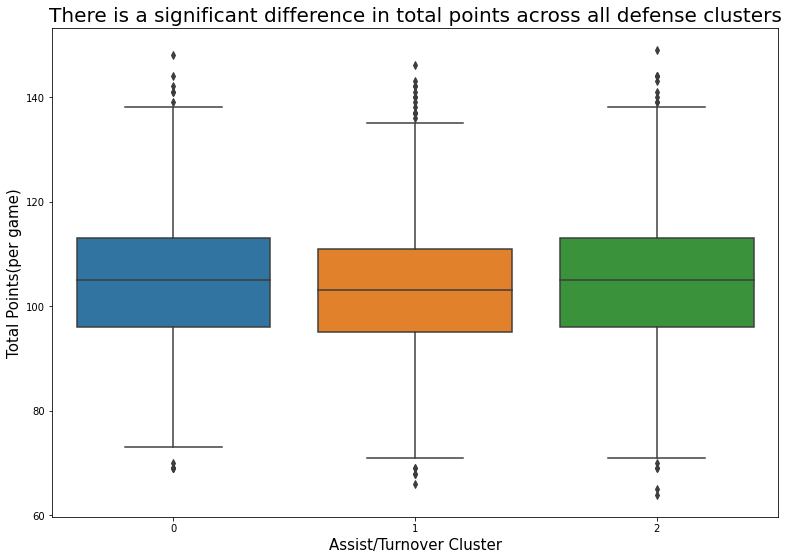

In [76]:
plt.figure(figsize = (13,9))
sns.boxplot(X_train.assist_turnover_cluster, y_train)
plt.title("There is a significant difference in total points across all defense clusters", size = 20)
plt.xlabel("Assist/Turnover Cluster", size = 15)
plt.ylabel("Total Points(per game)", size = 15)
plt.show()

**Takeaway:**
- Since there is a significant difference, we will add them to our validate and test data set.

### Opponent Shooting Cluster

In [83]:
opp_shooting_vars

['Opp.FieldGoals._scaled', 'Opp.3PointShots._scaled', 'Opp.FreeThrows._scaled']

     k         sse
0    2  182.461534
1    3  149.269762
2    4  125.740409
3    5  113.193404
4    6  101.101995
5    7   92.915821
6    8   85.748968
7    9   80.107937
8   10   75.500602
9   11   71.343994
10  12   67.776351
11  13   64.903262
12  14   62.348063
13  15   59.730022
14  16   57.356435
15  17   55.190490
16  18   53.246844
17  19   51.457784


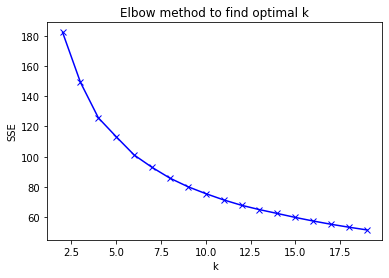

In [84]:
elbow_plot(opp_shooting_vars, X_train_scaled)

In [85]:
train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['Opp.FieldGoals._scaled', 'Opp.3PointShots._scaled', 'Opp.FreeThrows._scaled'], 
                                    cluster_col_name = 'opp_shooting_cluster', X_train_scaled = X_train_scaled)

In [86]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'opp_shooting_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

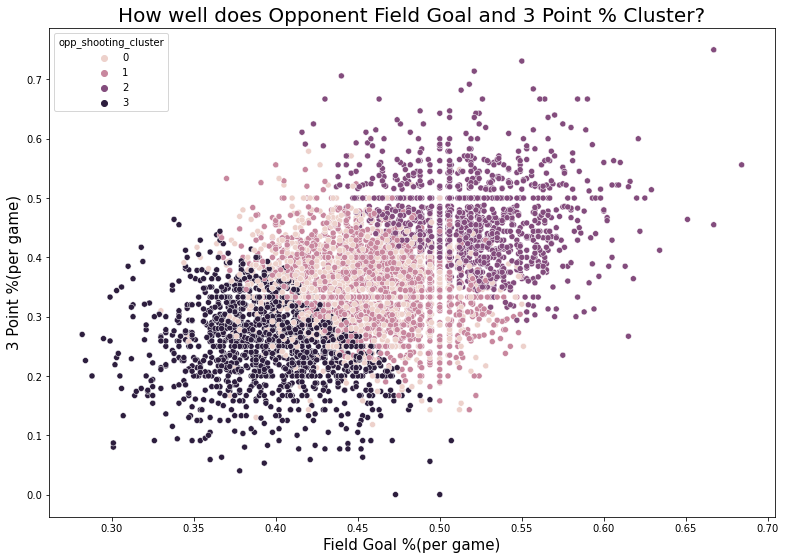

In [87]:
plt.figure(figsize = (13,9))
sns.scatterplot(x='Opp.FieldGoals.', y='Opp.3PointShots.', hue='opp_shooting_cluster', data=X_train)
plt.title("How well does Opponent Field Goal and 3 Point % Cluster?", size = 20)
plt.xlabel("Field Goal %(per game)", size = 15)
plt.ylabel("3 Point %(per game)", size = 15)
plt.show()

**Takeaway:**
- cluster 0 and 4 seem to have a clear defined area between them but the other 2 clusters blend a significant amount
- There seems to be a linear relationship between the shooting percentages. As one increases so does the other
- This looks near identical to the shooting cluster

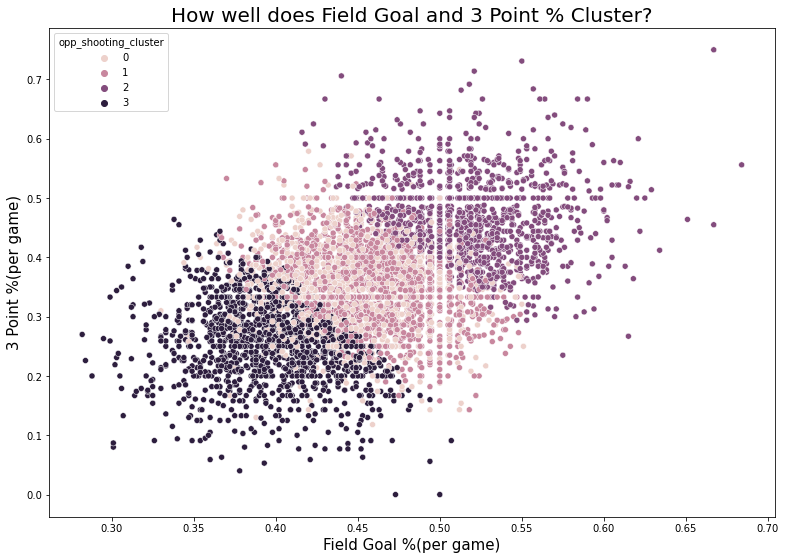

In [90]:
plt.figure(figsize = (13,9))
sns.scatterplot(x='Opp.FieldGoals.', y='Opp.3PointShots.', hue='opp_shooting_cluster', data=X_train)
plt.title("How well does Field Goal and 3 Point % Cluster?", size = 20)
plt.xlabel("Field Goal %(per game)", size = 15)
plt.ylabel("3 Point %(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
plt.figure(figsize = (13,9))
sns.scatterplot(x='FieldGoals.', y='X3PointShots.', hue='shooting_cluster', data=X_train)
plt.title("How well does Field Goal and 3 Point % Cluster?", size = 20)
plt.xlabel("Field Goal %(per game)", size = 15)
plt.ylabel("3 Point %(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Steals, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Steals with respect to Points scored?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Blocks, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Blocks with respect to Points scored?", size = 20)
plt.xlabel("Blocks(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Blocks, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Blocks with respect to Points scored?", size = 20)
plt.xlabel("Blocks(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

### Is there a significant difference in total points scored between assist/turnover clusters?

- $H_0$: The total points scored is the same across all assist/turnover clusters
- $H_a$: The total points scored is not the same across all assist/turnover clusters

In [ ]:
cluster0 = train[train.assist_turnover_cluster == 0].TeamPoints
cluster1 = train[train.assist_turnover_cluster == 1].TeamPoints
cluster2 = train[train.assist_turnover_cluster == 2].TeamPoints

In [ ]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

In [ ]:
plt.figure(figsize = (13,9))
sns.boxplot(X_train.assist_turnover_cluster, y_train)
plt.title("There is a significant difference in total points across all defense clusters", size = 20)
plt.xlabel("Assist/Turnover Cluster", size = 15)
plt.ylabel("Total Points(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

### Opponent Defense Cluster

In [ ]:
opp_defense_vars

In [ ]:
elbow_plot(opp_defense_vars, X_train_scaled)

In [ ]:
train_clusters, kmeans = run_kmeans(3,  cluster_vars = ['Steals_scaled', 'Blocks_scaled'], 
                                    cluster_col_name = 'defense_cluster', X_train_scaled = X_train_scaled)

In [ ]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'defense_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

In [ ]:
plt.figure(figsize = (13,9))
sns.color_palette("tab10")
sns.scatterplot(x='Steals', y='Blocks', hue='defense_cluster', data=X_train, palette = 'Set1')
plt.title("How well does Steals and Blocks Cluster?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Blocks(per game)", size = 15)
plt.show()

**Takeaways:**

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Steals, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Steals with respect to Points scored?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Steals, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Steals with respect to Points scored?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

### Is there a significant difference in total points scored between assist/turnover clusters?

- $H_0$: The total points scored is the same across all assist/turnover clusters
- $H_a$: The total points scored is not the same across all assist/turnover clusters

In [ ]:
cluster0 = train[train.assist_turnover_cluster == 0].TeamPoints
cluster1 = train[train.assist_turnover_cluster == 1].TeamPoints
cluster2 = train[train.assist_turnover_cluster == 2].TeamPoints

In [ ]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

In [ ]:
plt.figure(figsize = (13,9))
sns.boxplot(X_train.assist_turnover_cluster, y_train)
plt.title("There is a significant difference in total points across all defense clusters", size = 20)
plt.xlabel("Assist/Turnover Cluster", size = 15)
plt.ylabel("Total Points(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

### Opponent Assist/Turnover Cluster

In [ ]:
opp_assist_turnover_vars

In [ ]:
elbow_plot(opp_assist_turnover_vars, X_train_scaled)

In [ ]:
train_clusters, kmeans = run_kmeans(3,  cluster_vars = ['Steals_scaled', 'Blocks_scaled'], 
                                    cluster_col_name = 'defense_cluster', X_train_scaled = X_train_scaled)

In [ ]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'defense_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

In [ ]:
plt.figure(figsize = (13,9))
sns.color_palette("tab10")
sns.scatterplot(x='Steals', y='Blocks', hue='defense_cluster', data=X_train, palette = 'Set1')
plt.title("How well does Steals and Blocks Cluster?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Blocks(per game)", size = 15)
plt.show()

**Takeaway:**

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Steals, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Steals with respect to Points scored?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
plt.figure(figsize = (13,9))
plt.scatter(train.Steals, train.TeamPoints, c=X_train.defense_cluster)
plt.title("How about Steals with respect to Points scored?", size = 20)
plt.xlabel("Steals(per game)", size = 15)
plt.ylabel("Total Points scored(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

In [ ]:
train = pd.concat([train, train_clusters], axis=1)
train.info()

### Is there a significant difference in total points scored between assist/turnover clusters?

- $H_0$: The total points scored is the same across all assist/turnover clusters
- $H_a$: The total points scored is not the same across all assist/turnover clusters

In [ ]:
cluster0 = train[train.assist_turnover_cluster == 0].TeamPoints
cluster1 = train[train.assist_turnover_cluster == 1].TeamPoints
cluster2 = train[train.assist_turnover_cluster == 2].TeamPoints

In [ ]:
if p < alpha:
    print("We reject the null")
else:
    print("We fail to reject the null")
p

In [ ]:
plt.figure(figsize = (13,9))
sns.boxplot(X_train.assist_turnover_cluster, y_train)
plt.title("There is a significant difference in total points across all defense clusters", size = 20)
plt.xlabel("Assist/Turnover Cluster", size = 15)
plt.ylabel("Total Points(per game)", size = 15)
plt.show()

**Takeaway:**
- The most blocks cluster is clearly defined but the low blocks is mixed

## Model

#### Ranking our Features

In [ ]:
lm = LinearRegression()
rfe_ = RFE(lm, 1)
rfe_.fit(X_train_scaled, y_train)
ranks = rfe_.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).sort_values('rank')

- Our top seven features are related to points which makes sense. 
- If the oppposing team shoots worse and then that gives the other team will grab more rebounds, starting another possession or opportunity to score some points.
- If the opposing team fouls the other team, then the end result may end with a trip to the free throw line for "free points."
- If the team is sharing the ball and looking for the open man then points will come easier.

#### Setting a Baseline

In [ ]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
y_hat = lm.predict(X_train_scaled)

baseline_rmse = round(mean_squared_error(y_train, y_hat)**(1/2), 7)
baseline_rmse

### Model 1 (No Cluster)
- We will choose our top "5" features

In [ ]:
X_train_model1 = X_train_scaled[['FieldGoals._scaled', 'TotalRebounds_scaled', 'Opp.FieldGoals._scaled', 'Opp.TotalRebounds_scaled', 'Opp.TotalFouls_scaled', 'FreeThrows._scaled', 'X3PointShots._scaled', 'Assists_scaled']]

In [ ]:
lm_rmse = round(linearReg_train(X_train_model1, y_train),7)

lm_rmse

In [ ]:
lars_rmse = round(lassoLars_train(X_train_model1, y_train),7)

lars_rmse

In [ ]:
lm_squared_rmse = round(poly_linearReg_train(X_train_model1, y_train, 2),7)

lm_squared_rmse